In [1]:
import random
from colorutils import Color
from generation_utils import get_random_color_pair, get_tiled_option_cfgs
from configs import CFG1, TextBoxCFG, ImageCFG, Point, Margin
from generators import generate_data
from PIL import ImageFont
from random import randint, choice
from utils import split_sentence


# データ準備

In [2]:
from pathlib import Path
import pandas as pd

all_messages = pd.read_csv("texts/messages.csv")
def iloc2(group):
    return group.head(2).tail(1)

messages = all_messages.groupby("char").apply(iloc2)  # train
# messages = all_messages.groupby("char").first()  # validation
names = pd.read_csv("texts/names.csv")

bgimage_paths = list(Path("bgimages").rglob(pattern="*.png"))
fgimage_paths = list(Path("fgimages").rglob(pattern="*.png"))
messages.shape, names.shape, len(bgimage_paths), len(fgimage_paths)

((5254, 5), (6480, 5), 976, 354)

In [3]:
messages.head(1)

,,char,word,text,text_ruby_hiragana,text_ruby_katakana
char,,,,,,
1,15016,1,第1期線,第1期線。第2期の線は、まだ動きませんが? まだ動けないのでしょうか!?︎ この期に及んで....,第1<ruby>期線<rt>きせん</rt></ruby>。第2<ruby>期<rt>き</...,第1<ruby>期線<rt>キセン</rt></ruby>。第2<ruby>期<rt>キ</...


In [4]:
import glob
message_fonts = glob.glob("fonts/fonts_message/*")
ruby_fonts = glob.glob("fonts/fonts_ruby/*")
len(message_fonts), len(ruby_fonts)

(11, 10)

# Niji

In [5]:
def generate_niji():
    cfg = CFG1()

    # 名前
    if random.random() < 0.5:
        name, name_ruby_hira, name_ruby_kata = names.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
        cfg.namebox.text = name  #random.choice([name, name_ruby_hira, name_ruby_kata])
        cfg.namebox.font = ImageFont.truetype(font=random.choice(message_fonts), size=60) 
        cfg.namebox.font_hex = "#ffffff"
        cfg.namebox.bg_hex = Color(hsv=(random.uniform(0, 360), 0.7, 0.7)).hex
        cfg.namebox.bg_alpha = randint(160, 220)
    cfg.namebox.tl = Point(180, 650)
    cfg.namebox.br = Point(840, cfg.namebox.tl.y + cfg.namebox.minheight)

    # メッセージ
    text, text_ruby_hira, text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
    cfg.msgbox.text = text  #random.choice([text, text_ruby_hira, text_ruby_kata])
    cfg.msgbox.font = ImageFont.truetype(font=random.choice(message_fonts), size=randint(50, 60))
    cfg.msgbox.bg_alpha = randint(160, 220)

    font_hex, bg_hex = get_random_color_pair(s=0)
    cfg.msgbox.font_hex = font_hex
    cfg.msgbox.bg_hex = bg_hex

    cfg.msgbox.margin = Margin(top=80, right=200, left=200, bottom=10)
    cfg.msgbox.tl = Point(60, 700)
    cfg.msgbox.br = Point(1920-60, 990)


    # 背景画像
    cfg.bg_cfg = ImageCFG(path=random.choice(bgimage_paths))

    # キャラクター画像
    n_fg_images = random.choice([0, 1, 2])
    cfg.character_cfg_list = [
        ImageCFG(path=random.choice(fgimage_paths), tl=Point((cfg.W // n_fg_images)*i - 200, 0))
        for i in range(1, n_fg_images+1)]
    
    # 選択肢
    optionbox_list = []
    nrow = random.choice([0, 1, 2, 3, 4])
    ncol = random.choice([0, 1, 2])

    for _ in range(max(0, random.choice([nrow*ncol, nrow*ncol-1]))):
        option_text = split_sentence(messages.sample(1)["text"].values[0])[0]
        # option_text = split_sentence(messages.sample(1)]["text_ruby_hiragana"].values[0])[0]
        option_cfg = TextBoxCFG()
        option_cfg.text = option_text
        option_cfg.tl = Point(270, 200)
        option_cfg.br = Point(1660, 600)
        option_cfg.font_hex = Color(hsv=(random.uniform(0, 360), 0.7, 0.8)).hex
        optionbox_list.append(option_cfg)
    
    # タイルレイアウト
    if len(optionbox_list) > 0:
        cfg.optionbox_list = get_tiled_option_cfgs(
            nrow=nrow, ncol=ncol, tl=Point(x=270, y=100), br=Point(x=1660, y=600), cfgs=optionbox_list
            )
    output = generate_data(cfg)
    gt_obj = {
        "gt_parse":{"messages":[output.text], "names":[output.name_text], "options":output.option_texts},
        "gt_parse_ruby":{"messages":[output.text_ruby], "names":[output.name_text_ruby], "options":output.option_texts_ruby},
        "meta":{"version":"0.2.0", "split":"train", "image_size":{"width":cfg.W, "height":cfg.H}}
        }
    return output.image, gt_obj

In [6]:
import json
import datasets
from datasets import Dataset
images, gts = [], []
from tqdm import tqdm
for i in tqdm(range(1, 2011)):
    try:
        image, gt = generate_niji()
        output_image_path = f"output_images/{i:05d}.png"
        # display(gt, image)
        image.save(output_image_path)
        images.append(output_image_path)
        gts.append(gt)
    except Exception as e:
        print(i, e)

    if len(images) == 200:
        df = pd.DataFrame([[img, json.dumps(gt, ensure_ascii=False)] for img, gt in zip(images, gts)], columns=["image", "ground_truth"])
        ds = Dataset.from_pandas(df)
        ds = ds.cast_column("image", datasets.Image())
        ds.save_to_disk(f"output_datasets/dataset_{i}")
        images, gts = [], []

 10%|▉         | 199/2010 [03:33<26:41,  1.13it/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

 20%|█▉        | 399/2010 [07:09<29:24,  1.10s/it]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

 30%|██▉       | 599/2010 [10:39<24:47,  1.05s/it]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

 40%|███▉      | 799/2010 [13:57<19:57,  1.01it/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

 50%|████▉     | 999/2010 [17:16<17:13,  1.02s/it]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

 60%|█████▉    | 1199/2010 [20:36<14:30,  1.07s/it]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

 70%|██████▉   | 1399/2010 [23:52<10:02,  1.01it/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

 80%|███████▉  | 1599/2010 [27:01<06:45,  1.01it/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

 90%|████████▉ | 1799/2010 [30:22<03:26,  1.02it/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

 99%|█████████▉| 1999/2010 [33:39<00:10,  1.05it/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

100%|██████████| 2010/2010 [33:54<00:00,  1.01s/it]


In [7]:
dss = []
for i in range(200, 2001, 200):
    dss.append(datasets.load_from_disk(f"output_datasets/dataset_{i}"))
ds = datasets.concatenate_datasets(dss)
ds.save_to_disk("output_datasets/dataset_niji")

Saving the dataset (0/9 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
import json
import datasets
from datasets import Dataset
images, gts = [], []
for i in range(1, 11):
    image, gt = generate_niji()
    output_image_path = f"output_images/{i:05d}.png"
    # display(gt, image)
    image.save(output_image_path)
    images.append(output_image_path)
    gts.append(gt)


# OLD

# FGO(OLD)

In [ ]:
def generate_standard():
    cfg = CFG1()

    # 名前
    if random.random() < 0.5:
        name, name_ruby_hira, name_ruby_kata = names.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
        cfg.name_text = random.choice([name, name_ruby_hira, name_ruby_kata])
        cfg.name_font_path = random.choice(message_fonts)

    # メッセージ
    text, text_ruby_hira, text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
    cfg.text = random.choice([text, text_ruby_hira, text_ruby_kata])
    cfg.msg_font_path = random.choice(message_fonts)
    
    # 選択肢
    n_options = random.choice([0, 0, 0, 0, 0, 1, 1, 1, 2, 2])
    if n_options == 1:
        cfg.optionbox_tl_list = [(230, (250+435)//2)]
        cfg.optionbox_br_list = [(1680, (385+570)//2)]
    elif n_options == 0:
        cfg.optionbox_tl_list = []
        cfg.optionbox_br_list = []
    option_texts = []
    for _ in range(n_options):
        op_text, op_text_ruby_hira, op_text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
        op_target_text = random.choice([op_text, op_text_ruby_hira, op_text_ruby_kata])
        op_target_text = random.choice(split_sentence(op_target_text)) # messagesのtextから選択肢には1文だけ取り出して使う
        option_texts.append(op_target_text)
    cfg.option_texts = option_texts
    cfg.option_font_path = random.choice(message_fonts)
    cfg.option_ruby_font_path = random.choice(ruby_fonts)

    # 背景画像
    bg_path = random.choice(bgimage_paths)
    cfg.bg_path = bg_path

    # 人物などの画像
    n_fg_images = random.choice([0, 1, 2])
    if n_fg_images == 1:
        cfg.fg_tl_list = [(500, 100)]
    elif n_fg_images == 2:
        cfg.fg_tl_list = [(200, 100), (1000, 100)]

    cfg.fg_pathlist = random.sample(fgimage_paths, n_fg_images)

    output = create_image(cfg)
    gt_obj = {
        "gt_parse":{"messages":[output.text], "names":[output.name_text], "options":output.option_texts},
        "meta":{"version":"0.1.0", "split":"train", "image_size":{"width":cfg.W, "height":cfg.H}}
        }
    return output.image, gt_obj

# Random(OLD)

In [ ]:

def generate_random():
    cfg = CFG1()

    # 名前
    if random.random() < .75:
        name, name_ruby_hira, name_ruby_kata = names.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
        cfg.name_text = choice([name, name_ruby_hira, name_ruby_kata])
        cfg.name_font_path = choice(message_fonts)
        cfg.name_font_color, cfg.namebox_hex = get_random_color_pair()
        cfg.namebox_alpha = randint(80, 255)
    minheight = cfg.namebox_minheight()
    is_namebox_above = random.random() < 0.5  # nameboxをmsgboxの上に配置するか下に配置するか
    cfg.namebox_tl = (
        choice([randint(10, 100), randint(540, 700)]),
        randint(600, 750) if is_namebox_above else randint(1080-(minheight+100), 1080-(minheight+10))
        )
    cfg.namebox_br = (cfg.namebox_tl[0] + randint(400, 800), cfg.namebox_tl[1] + randint(minheight, minheight+10))

    # メッセージ
    text, text_ruby_hira, text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
    cfg.text = choice([text, text_ruby_hira, text_ruby_kata])
    cfg.msg_font_path = choice(message_fonts)
    cfg.msg_font_color, cfg.msgbox_hex = get_random_color_pair()
    cfg.msgbox_alpha = randint(160, 255)
    cfg.msg_font_size = randint(36, 55)
    cfg.msg_ruby_font_size = randint(16, 24)
    cfg.msgbox_tl = (
        randint(20, 300),
        randint(cfg.namebox_br[1]-cfg.msg_margin.top, cfg.namebox_br[1]-cfg.msg_margin.top+50) if is_namebox_above else randint(540, 700)
        )
    cfg.msgbox_br = (
        randint(1600, 1880),
        randint(1000, 1055) if is_namebox_above else randint(cfg.namebox_tl[1]-30, cfg.namebox_tl[1]+10)
    )
    # 選択肢
    n_options = random.choice([0, 0, 0, 0, 0, 1, 1, 1, 2, 2])
    optionbox_centor = randint(800, 1100)
    optionbox_halfwidth = randint(500, 700)
    optionbox_height = randint(cfg.optionbox_minheight(), cfg.optionbox_minheight()+10)
    optionbox_top = randint(120, 250)
    cfg.optionbox_tl_list = [
        (optionbox_centor-optionbox_halfwidth, optionbox_top),
        (optionbox_centor-optionbox_halfwidth, optionbox_top + optionbox_height+ randint(10, 50))
    ]
    cfg.optionbox_br_list = [
        (optionbox_centor+optionbox_halfwidth, cfg.optionbox_tl_list[0][1]+optionbox_height),
        (optionbox_centor+optionbox_halfwidth, cfg.optionbox_tl_list[1][1]+optionbox_height)
    ]
    if n_options == 1:
        cfg.optionbox_tl_list = [(optionbox_centor-optionbox_halfwidth, (cfg.optionbox_tl_list[0][1]+cfg.optionbox_tl_list[1][1])//2)]
        cfg.optionbox_br_list = [(optionbox_centor+optionbox_halfwidth, (cfg.optionbox_br_list[0][1]+cfg.optionbox_br_list[1][1])//2)]
    elif n_options == 0:
        cfg.optionbox_tl_list = []
        cfg.optionbox_br_list = []
    option_texts = []
    for _ in range(n_options):
        op_text, op_text_ruby_hira, op_text_ruby_kata = messages.sample(1)[["text", "text_ruby_hiragana", "text_ruby_katakana"]].values[0]
        op_target_text = random.choice([op_text, op_text_ruby_hira, op_text_ruby_kata])
        op_target_text = random.choice(split_sentence(op_target_text)) # messagesのtextから選択肢には1文だけ取り出して使う
        option_texts.append(op_target_text)
    cfg.option_texts = option_texts
    cfg.option_font_path = random.choice(message_fonts)
    cfg.option_ruby_font_path = random.choice(ruby_fonts)
    cfg.option_font_color, cfg.optionbox_hex = get_random_color_pair()
    cfg.optionbox_alpha = random.randint(160, 255)
    cfg.option_font_size = random.randint(36, 60)
    cfg.option_ruby_font_size = random.randint(16, 24)

    # 背景画像
    bg_path = random.choice(bgimage_paths)
    cfg.bg_path = bg_path

    # 人物などの画像
    n_fg_images = random.choice([0, 1, 2])
    if n_fg_images == 1:
        cfg.fg_tl_list = [(500, 100)]
    elif n_fg_images == 2:
        cfg.fg_tl_list = [(200, 100), (1000, 100)]

    cfg.fg_pathlist = random.sample(fgimage_paths, n_fg_images)

    output = create_image(cfg)
    gt_obj = {
        "gt_parse":{"messages":[output.text], "names":[output.name_text], "options":output.option_texts},
        "meta":{"version":"0.1.0", "split":"train", "image_size":{"width":cfg.W, "height":cfg.H}}
        }
    return output.image, gt_obj

In [ ]:
# dss = []
# for i in range(200, 1801, 200):
#     dss.append(datasets.load_from_disk(f"output_datasets/dataset_{i}"))
# ds = datasets.concatenate_datasets(dss)
# ds.save_to_disk("output_datasets/dataset_random")

In [8]:
ds = Dataset.load_from_disk(f"output_datasets/dataset_niji")
ds

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 2000
})

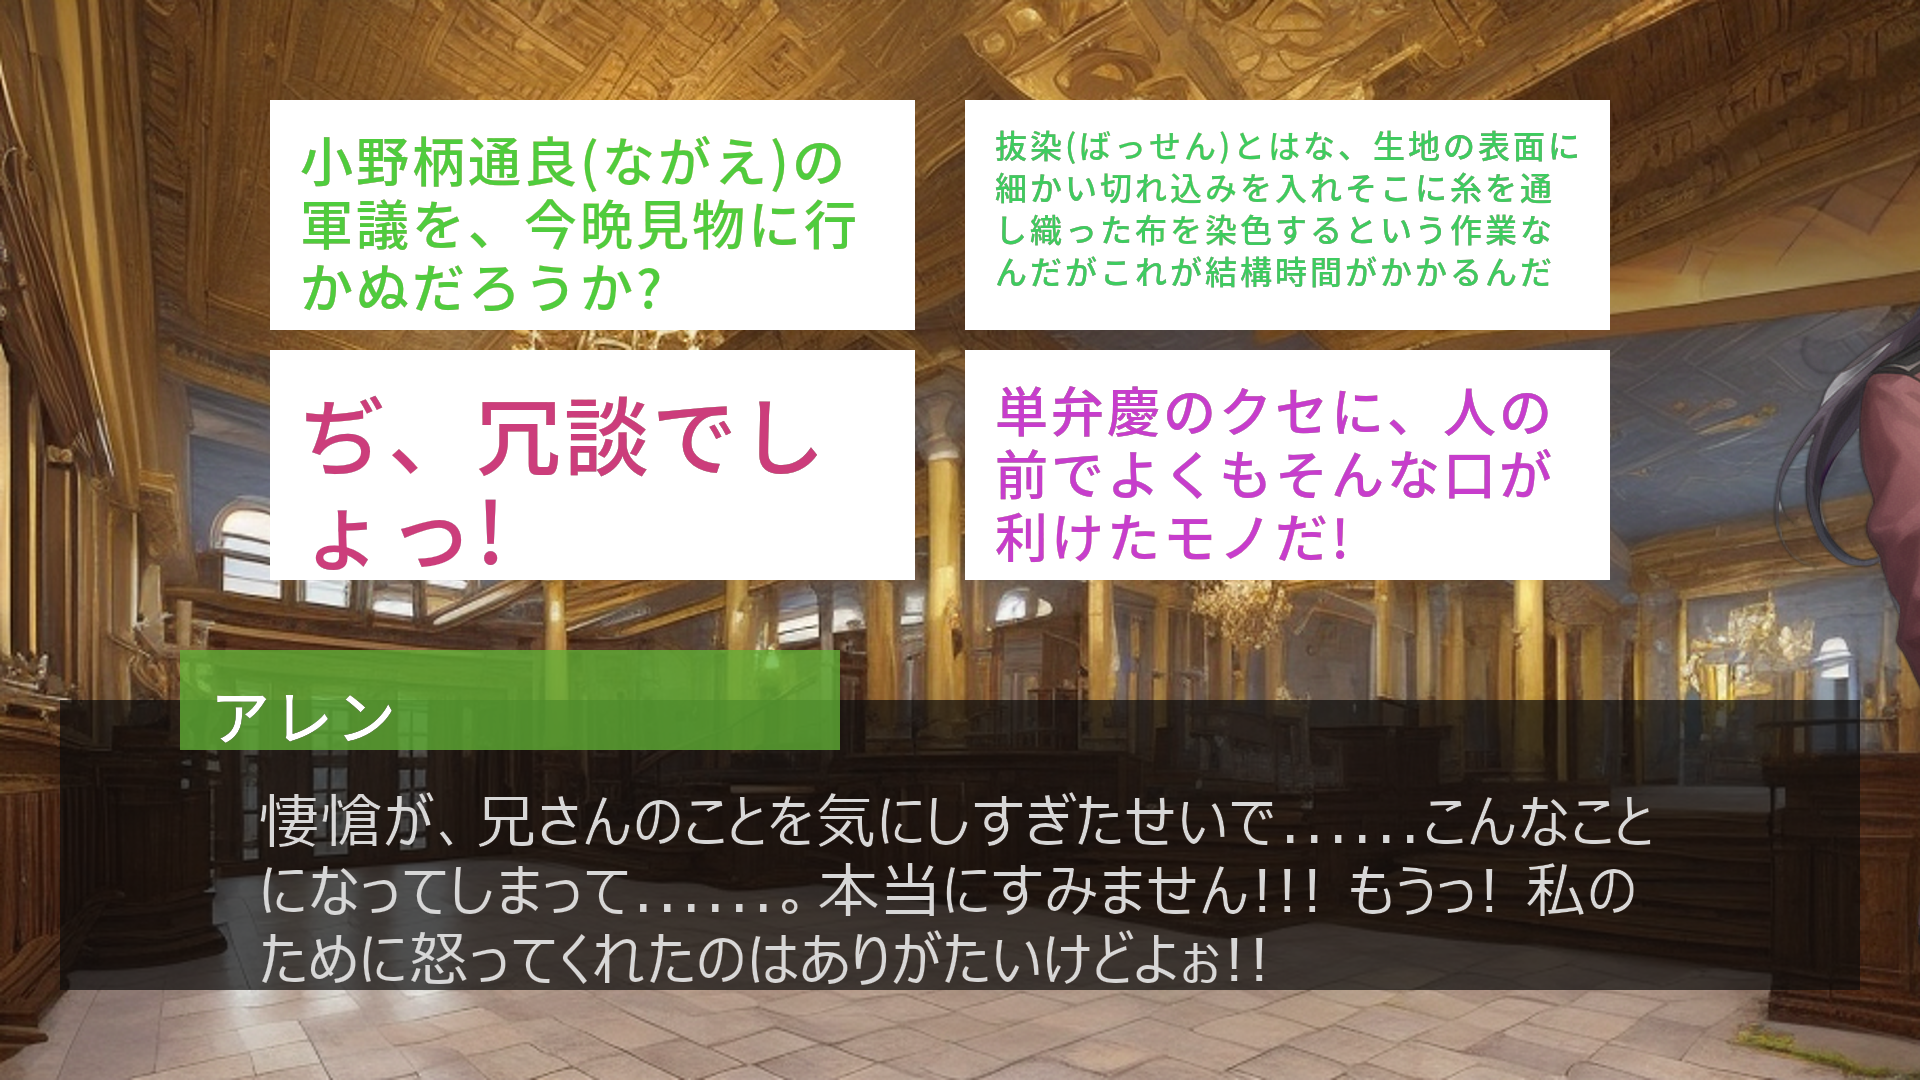

In [11]:
ds[1992]["image"]

In [13]:
json.loads(ds[1992]["ground_truth"])

{'gt_parse': {'messages': ['悽愴が、兄さんのことを気にしすぎたせいで......こんなことになってしまって......。本当にすみません!!! もうっ! 私のために怒ってくれたのはありがたいけどよぉ!!'],
  'names': ['アレン'],
  'options': ['小野柄通良(ながえ)の軍議を、今晩見物に行かぬだろうか?',
   '抜染(ばっせん)とはな、生地の表面に細かい切れ込みを入れそこに糸を通し織った布を染色するという作業なんだがこれが結構時間がかかるんだ',
   'ぢ、冗談でしょっ!',
   '単弁慶のクセに、人の前でよくもそんな口が利けたモノだ!']},
 'gt_parse_ruby': {'messages': ['悽愴が、兄さんのことを気にしすぎたせいで......こんなことになってしまって......。本当にすみません!!! もうっ! 私のために怒ってくれたのはありがたいけどよぉ!!'],
  'names': ['アレン'],
  'options': ['小野柄通良(ながえ)の軍議を、今晩見物に行かぬだろうか?',
   '抜染(ばっせん)とはな、生地の表面に細かい切れ込みを入れそこに糸を通し織った布を染色するという作業なんだがこれが結構時間がかかるんだ',
   'ぢ、冗談でしょっ!',
   '単弁慶のクセに、人の前でよくもそんな口が利けたモノだ!']},
 'meta': {'version': '0.2.0',
  'split': 'train',
  'image_size': {'width': 1920, 'height': 1080}}}